# Regression and Analysis of the Heart Disease Data

This has 3 parts
1. Build a logistic model to predict the heart disease based on the dataset provided.
2. Analyse the correlation between Heart disease, kidney disease, diabetes and skin cancer. See if there is a relation between them.
3. Understand the influence of BMI on the diseases.

## 1. Build a logistic model to predict the heart disease based on the dataset provided.

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
# Read the csv file and check the top 5 rows
heart = pd.read_csv("heart_2020_cleaned.csv")
heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [12]:
# Check for null values
heart.isnull().any()
heart.shape

(319795, 18)

In [13]:
heart.Diabetic.value_counts()

Diabetic
No                         269653
Yes                         40802
No, borderline diabetes      6781
Yes (during pregnancy)       2559
Name: count, dtype: int64

In [14]:
# Since we want to diagnose as Yes for heart-disease, even if there is a slightest chance, let us consider borderline diabetic and pregnancy diabetic as No.
heart['Diabetic'] = heart.Diabetic.apply(lambda x: 'No' if x == 'No, borderline diabetes' or x == 'Yes (during pregnancy)' else x)
heart.Diabetic.value_counts()

Diabetic
No     278993
Yes     40802
Name: count, dtype: int64

In [15]:
# Check for null values
heart.isnull().any()

HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking         False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

### Data analysis of categorical features

In [16]:
# Notice that we have a few categorical variables with Yes/No values. Let us convert them to binary 1/0
column_yesno = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "Diabetic", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

heart[column_yesno] = heart[column_yesno].apply(lambda x: x.map({'Yes':1,'No':0}))
heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,Female,55-59,White,1,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,Female,80 or older,White,0,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,Male,65-69,White,1,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,Female,75-79,White,0,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,Female,40-44,White,0,1,Very good,8.0,0,0,0


In [17]:
# Check the data
heart.info()
heart_orig = heart

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  int64  
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  int64  
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  int64  
 16  KidneyDisease     31

In [18]:
# We can find 4 more categorical variables which are not yes/no. The dtype is object for these 4. Let us convert them into dummy variables.
categoricals = heart.select_dtypes(include=['object'])
categoricals.head()
cat_dummies = pd.get_dummies(categoricals, drop_first=True)
cat_dummies.head()
# Drop the redundant columns
heart.drop(list(categoricals.columns), axis=1, inplace=True)
# concat the heart and dummies data frames.
heart = pd.concat([heart, cat_dummies], axis=1)
heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,...,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,16.60,1,0,0,3.0,30.0,0,1,1,...,False,False,False,False,False,True,False,False,False,True
1,0,20.34,0,0,1,0.0,0.0,0,0,1,...,True,False,False,False,False,True,False,False,False,True
2,0,26.58,1,0,0,20.0,30.0,0,1,1,...,False,False,False,False,False,True,True,False,False,False
3,0,24.21,0,0,0,0.0,0.0,0,0,0,...,False,False,False,False,False,True,False,True,False,False
4,0,23.71,0,0,0,28.0,0.0,1,0,1,...,False,False,False,False,False,True,False,False,False,True


In [19]:
# Here we are interested in the chance of having the heart disease based on other variables.
# Let y be HeartDisease column
y = heart.pop('HeartDisease')
X = heart
X.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,SleepTime,...,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,16.60,1,0,0,3.0,30.0,0,1,1,5.0,...,False,False,False,False,False,True,False,False,False,True
1,20.34,0,0,1,0.0,0.0,0,0,1,7.0,...,True,False,False,False,False,True,False,False,False,True
2,26.58,1,0,0,20.0,30.0,0,1,1,8.0,...,False,False,False,False,False,True,True,False,False,False
3,24.21,0,0,0,0.0,0.0,0,0,0,6.0,...,False,False,False,False,False,True,False,True,False,False
4,23.71,0,0,0,28.0,0.0,1,0,1,8.0,...,False,False,False,False,False,True,False,False,False,True


### Split the data into train and test

In [20]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
X_train.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,SleepTime,...,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
148821,25.10,0,0,0,0.0,0.0,0,0,1,7.0,...,False,False,False,False,False,True,False,True,False,False
113787,23.03,1,0,0,0.0,0.0,0,0,1,7.0,...,False,False,False,False,False,True,False,False,False,False
114251,27.17,1,0,0,0.0,0.0,0,0,1,5.0,...,False,False,False,True,False,False,False,False,False,False
311048,23.33,0,0,0,0.0,0.0,0,0,1,7.0,...,False,False,False,False,False,True,False,True,False,False
50914,28.89,0,0,0,0.0,0.0,0,1,0,8.0,...,True,False,False,False,False,True,False,True,False,False


In [21]:
len(X_train.columns)

35

In [22]:
# Scale X variables - should have done before spliting
from sklearn.preprocessing import scale
# rescale the features of Xtrain
cols = X_train.columns
X_train = pd.DataFrame(scale(X_train))
X_train.columns = cols
# rescale the features of Xtest
cols = X_test.columns
X_test = pd.DataFrame(scale(X_test))
X_test.columns = cols

In [23]:
?RFE

Object `RFE` not found.


In [24]:
# Let us use RFE to check required features and remove multicolearity
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=30)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [25]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('BMI', True, 1),
 ('Smoking', True, 1),
 ('AlcoholDrinking', True, 1),
 ('Stroke', True, 1),
 ('PhysicalHealth', True, 1),
 ('MentalHealth', True, 1),
 ('DiffWalking', True, 1),
 ('Diabetic', True, 1),
 ('PhysicalActivity', False, 5),
 ('SleepTime', True, 1),
 ('Asthma', True, 1),
 ('KidneyDisease', True, 1),
 ('SkinCancer', True, 1),
 ('Sex_Male', True, 1),
 ('AgeCategory_25-29', False, 2),
 ('AgeCategory_30-34', False, 3),
 ('AgeCategory_35-39', True, 1),
 ('AgeCategory_40-44', False, 4),
 ('AgeCategory_45-49', True, 1),
 ('AgeCategory_50-54', True, 1),
 ('AgeCategory_55-59', True, 1),
 ('AgeCategory_60-64', True, 1),
 ('AgeCategory_65-69', True, 1),
 ('AgeCategory_70-74', True, 1),
 ('AgeCategory_75-79', True, 1),
 ('AgeCategory_80 or older', True, 1),
 ('Race_Asian', True, 1),
 ('Race_Black', True, 1),
 ('Race_Hispanic', True, 1),
 ('Race_Other', False, 6),
 ('Race_White', True, 1),
 ('GenHealth_Fair', True, 1),
 ('GenHealth_Good', True, 1),
 ('GenHealth_Poor', True, 1),
 ('GenHe

In [26]:
rfe_columns = X_train.columns[rfe.support_]
rfe_columns

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Diabetic', 'SleepTime', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Sex_Male', 'AgeCategory_35-39',
       'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_Asian',
       'Race_Black', 'Race_Hispanic', 'Race_White', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good'],
      dtype='object')

In [27]:
# Creating X_train dataframe with RFE selected variables
X_train_rfe = X_train[rfe_columns]
X_train_rfe.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,SleepTime,Asthma,...,AgeCategory_75-79,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,Race_White,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,-0.507940,-0.837532,-0.26994,-0.197158,-0.423827,-0.490062,-0.401789,-0.381952,-0.067714,-0.394099,...,-0.268251,-0.286191,-0.161467,-0.278192,-0.305988,0.551911,-0.348666,1.562734,-0.192115,-0.744199
1,-0.833874,1.193984,-0.26994,-0.197158,-0.423827,-0.490062,-0.401789,-0.381952,-0.067714,-0.394099,...,-0.268251,-0.286191,-0.161467,-0.278192,-0.305988,0.551911,-0.348666,-0.639904,-0.192115,-0.744199
2,-0.182005,1.193984,-0.26994,-0.197158,-0.423827,-0.490062,-0.401789,-0.381952,-1.461953,2.537432,...,-0.268251,-0.286191,-0.161467,-0.278192,3.268097,-1.811886,-0.348666,-0.639904,-0.192115,-0.744199
3,-0.786637,-0.837532,-0.26994,-0.197158,-0.423827,-0.490062,-0.401789,-0.381952,-0.067714,-0.394099,...,-0.268251,-0.286191,-0.161467,-0.278192,-0.305988,0.551911,-0.348666,1.562734,-0.192115,-0.744199
4,0.088820,-0.837532,-0.26994,-0.197158,-0.423827,-0.490062,-0.401789,2.618128,0.629406,-0.394099,...,-0.268251,3.494164,-0.161467,-0.278192,-0.305988,0.551911,-0.348666,1.562734,-0.192115,-0.744199


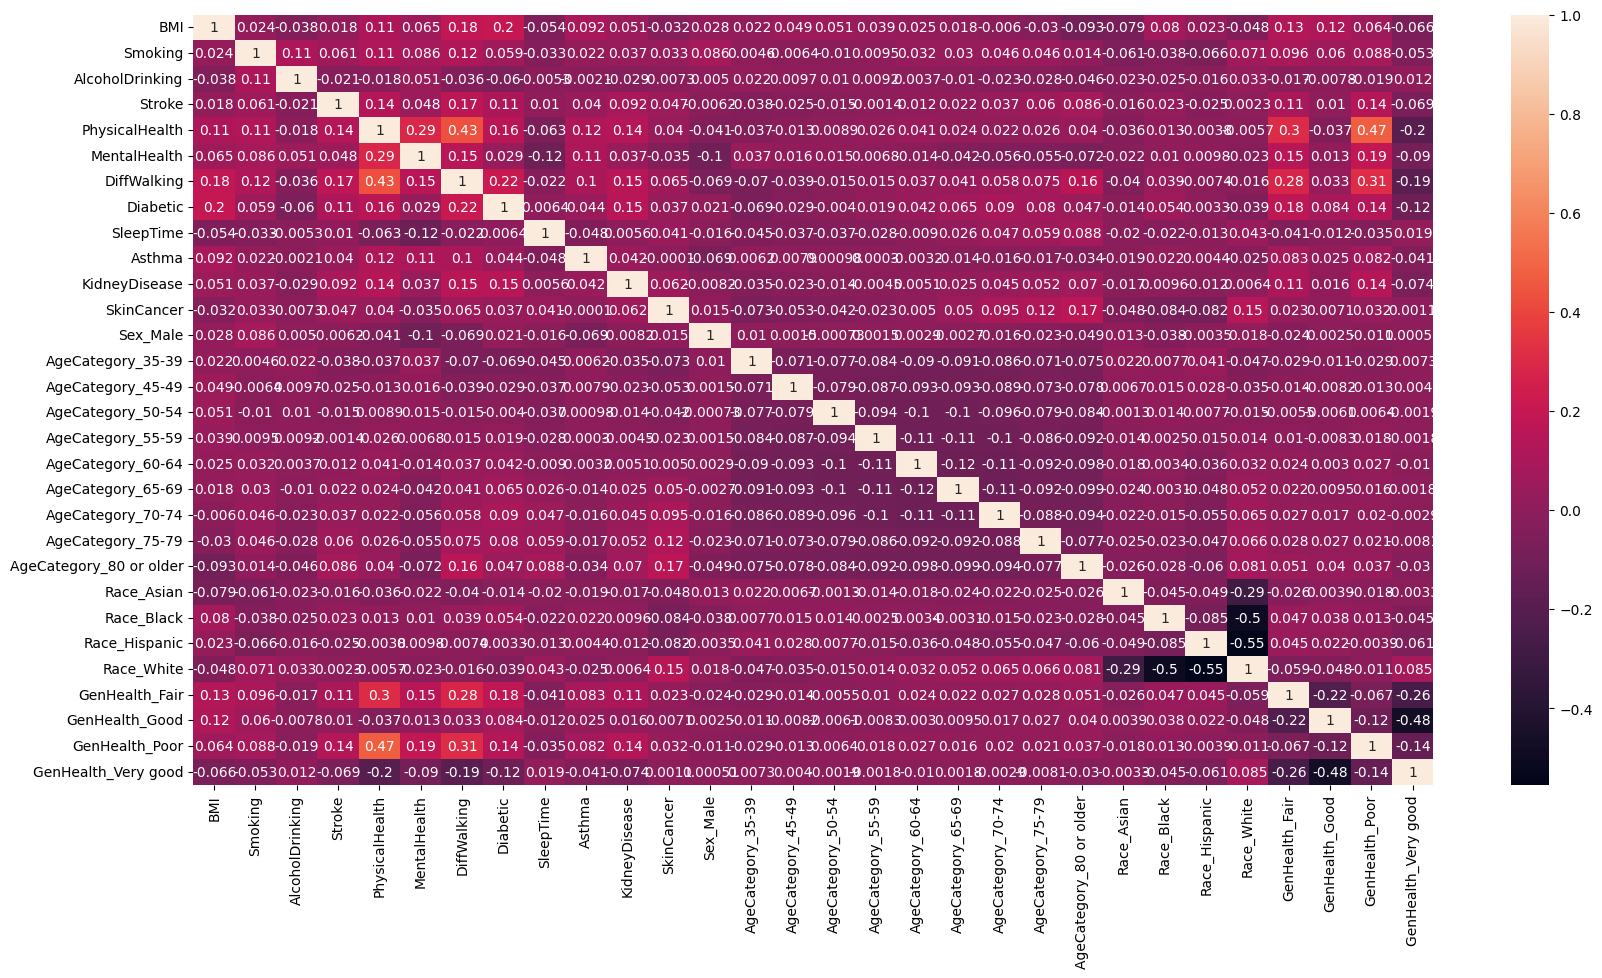

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20,10))
sns.heatmap(X_train_rfe.corr(),annot = True)
plt.show()

In [29]:
# build a linear model using statsmodel

import statsmodels.api as sm  
logm1 = sm.GLM(list(y_train),(sm.add_constant(X_train_rfe)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               223856
Model:                            GLM   Df Residuals:                   223825
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50699.
Date:                Sat, 02 Dec 2023   Deviance:                   1.0140e+05
Time:                        15:00:59   Pearson chi2:                 2.07e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1217
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.1626      0.014   -225.885      0.000      -3.190      -3.135
BMI                         0.0588      0.009      6.821      0.000       0.042       0.076
Smoking                     0.1846      0.008     21.824      0.000       0.168       0.201
AlcoholDrinking            -0.0568      0.010     -5.627      0.000      -0.077      -0.037
Stroke                      0.2004      0.005     38.796      0.000       0.190       0.211
PhysicalHealth              0.0157      0.008      1.906      0.057      -0.000       0.032
MentalHealth                0.0311      0.008      3.699      0.000       0.015       0.048
DiffWalking                 0.0676      0.007      9.079      0.000       0.053       0.082
Diabetic                    0.1593      0.007     24.098      0.000       0.146       0.172
SleepTime                  -0.0490      0.008     -6.537      0.000      -0.064      -0.034
Asthma                      0.0933      0.008     11.891      0.000       0.078       0.109
KidneyDisease               0.1047      0.006     19.023      0.000       0.094       0.116
SkinCancer                  0.0323      0.007      4.757      0.000       0.019       0.046
Sex_Male                    0.3513      0.009     40.504      0.000       0.334       0.368
AgeCategory_35-39           0.0115      0.020      0.575      0.565      -0.028       0.051
AgeCategory_45-49           0.2047      0.015     13.413      0.000       0.175       0.235
AgeCategory_50-54           0.3323      0.014     23.469      0.000       0.305       0.360
AgeCategory_55-59           0.4153      0.014     29.178      0.000       0.387       0.443
AgeCategory_60-64           0.5302      0.014     37.153      0.000       0.502       0.558
AgeCategory_65-69           0.5992      0.014     42.411      0.000       0.572       0.627
AgeCategory_70-74           0.6624      0.014     49.038      0.000       0.636       0.689
AgeCategory_75-79           0.6105      0.012     51.678      0.000       0.587       0.634
AgeCategory_80 or older     0.7136      0.012     57.779      0.000       0.689       0.738
Race_Asian                 -0.0752      0.014     -5.421      0.000      -0.102      -0.048
Race_Black                 -0.0804      0.013     -6.262      0.000      -0.106      -0.055
Race_Hispanic              -0.0565      0.014     -3.930      0.000      -0.085      -0.028
Race_White                 -0.0093      0.016     -0.572      0.568      -0.041       0.023
GenHealth_Fair              0.4811      0.012     39.509      0.000       0.457       0.505
GenHealth_Good              0.4765      0.016     29.677      0.000       0.445       0.508
GenHealth_Poor              0.3546      0.009     39.220      0.000       0.337       0.372
GenHealth_Very good         0.2247      0.017  

In [30]:
X_train_rfe = X_train_rfe.drop(['AgeCategory_35-39'], axis=1)
X_train_rfe.columns

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Diabetic', 'SleepTime', 'Asthma',
       'KidneyDisease', 'SkinCancer', 'Sex_Male', 'AgeCategory_45-49',
       'AgeCategory_50-54', 'AgeCategory_55-59', 'AgeCategory_60-64',
       'AgeCategory_65-69', 'AgeCategory_70-74', 'AgeCategory_75-79',
       'AgeCategory_80 or older', 'Race_Asian', 'Race_Black', 'Race_Hispanic',
       'Race_White', 'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good'],
      dtype='object')

In [31]:
# build a linear model using statsmodel

import statsmodels.api as sm  
logm1 = sm.GLM(list(y_train),(sm.add_constant(X_train_rfe)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               223856
Model:                            GLM   Df Residuals:                   223826
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50699.
Date:                Sat, 02 Dec 2023   Deviance:                   1.0140e+05
Time:                        15:01:02   Pearson chi2:                 2.07e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1217
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.1624      0.014   -226.047      0.000      -3.190      -3.135
BMI                         0.0589      0.009      6.833      0.000       0.042       0.076
Smoking                     0.1847      0.008     21.841      0.000       0.168       0.201
AlcoholDrinking            -0.0568      0.010     -5.627      0.000      -0.077      -0.037
Stroke                      0.2004      0.005     38.798      0.000       0.190       0.211
PhysicalHealth              0.0157      0.008      1.908      0.056      -0.000       0.032
MentalHealth                0.0310      0.008      3.695      0.000       0.015       0.048
DiffWalking                 0.0676      0.007      9.078      0.000       0.053       0.082
Diabetic                    0.1593      0.007     24.099      0.000       0.146       0.172
SleepTime                  -0.0491      0.008     -6.542      0.000      -0.064      -0.034
Asthma                      0.0933      0.008     11.888      0.000       0.078       0.109
KidneyDisease               0.1047      0.006     19.022      0.000       0.094       0.116
SkinCancer                  0.0323      0.007      4.757      0.000       0.019       0.046
Sex_Male                    0.3513      0.009     40.501      0.000       0.334       0.368
AgeCategory_45-49           0.2020      0.014     13.959      0.000       0.174       0.230
AgeCategory_50-54           0.3294      0.013     25.002      0.000       0.304       0.355
AgeCategory_55-59           0.4121      0.013     31.489      0.000       0.386       0.438
AgeCategory_60-64           0.5269      0.013     40.556      0.000       0.501       0.552
AgeCategory_65-69           0.5959      0.013     46.454      0.000       0.571       0.621
AgeCategory_70-74           0.6592      0.012     53.801      0.000       0.635       0.683
AgeCategory_75-79           0.6078      0.011     56.327      0.000       0.587       0.629
AgeCategory_80 or older     0.7107      0.011     63.110      0.000       0.689       0.733
Race_Asian                 -0.0752      0.014     -5.421      0.000      -0.102      -0.048
Race_Black                 -0.0804      0.013     -6.260      0.000      -0.106      -0.055
Race_Hispanic              -0.0565      0.014     -3.931      0.000      -0.085      -0.028
Race_White                 -0.0093      0.016     -0.569      0.570      -0.041       0.023
GenHealth_Fair              0.4812      0.012     39.511      0.000       0.457       0.505
GenHealth_Good              0.4765      0.016     29.678      0.000       0.445       0.508
GenHealth_Poor              0.3546      0.009     39.220      0.000       0.337       0.372
GenHealth_Very good         0.2248      0.017     12.908      0.000       0.191       0.259
===============================================

In [32]:
X_train_rfe = X_train_rfe.drop(['Race_White'], axis=1)
X_train_rfe.columns

import statsmodels.api as sm  
logm1 = sm.GLM(list(y_train),(sm.add_constant(X_train_rfe)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               223856
Model:                            GLM   Df Residuals:                   223827
Model Family:                Binomial   Df Model:                           28
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50699.
Date:                Sat, 02 Dec 2023   Deviance:                   1.0140e+05
Time:                        15:01:04   Pearson chi2:                 2.07e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1217
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.1623      0.014   -226.063      0.000      -3.190      -3.135
BMI                         0.0589      0.009      6.829      0.000       0.042       0.076
Smoking                     0.1848      0.008     21.856      0.000       0.168       0.201
AlcoholDrinking            -0.0568      0.010     -5.629      0.000      -0.077      -0.037
Stroke                      0.2005      0.005     38.815      0.000       0.190       0.211
PhysicalHealth              0.0156      0.008      1.903      0.057      -0.000       0.032
MentalHealth                0.0311      0.008      3.700      0.000       0.015       0.048
DiffWalking                 0.0677      0.007      9.092      0.000       0.053       0.082
Diabetic                    0.1594      0.007     24.125      0.000       0.146       0.172
SleepTime                  -0.0492      0.007     -6.556      0.000      -0.064      -0.034
Asthma                      0.0933      0.008     11.898      0.000       0.078       0.109
KidneyDisease               0.1047      0.006     19.021      0.000       0.094       0.116
SkinCancer                  0.0321      0.007      4.735      0.000       0.019       0.045
Sex_Male                    0.3513      0.009     40.499      0.000       0.334       0.368
AgeCategory_45-49           0.2019      0.014     13.954      0.000       0.174       0.230
AgeCategory_50-54           0.3293      0.013     24.996      0.000       0.303       0.355
AgeCategory_55-59           0.4119      0.013     31.485      0.000       0.386       0.438
AgeCategory_60-64           0.5266      0.013     40.562      0.000       0.501       0.552
AgeCategory_65-69           0.5955      0.013     46.474      0.000       0.570       0.621
AgeCategory_70-74           0.6588      0.012     53.840      0.000       0.635       0.683
AgeCategory_75-79           0.6075      0.011     56.376      0.000       0.586       0.629
AgeCategory_80 or older     0.7103      0.011     63.181      0.000       0.688       0.732
Race_Asian                 -0.0720      0.013     -5.681      0.000      -0.097      -0.047
Race_Black                 -0.0752      0.009     -8.389      0.000      -0.093      -0.058
Race_Hispanic              -0.0508      0.010     -4.901      0.000      -0.071      -0.030
GenHealth_Fair              0.4812      0.012     39.520      0.000       0.457       0.505
GenHealth_Good              0.4766      0.016     29.684      0.000       0.445       0.508
GenHealth_Poor              0.3547      0.009     39.238      0.000       0.337       0.372
GenHealth_Very good         0.2247      0.017     12.905      0.000       0.191       0.259
===========================================================================================
"""

In [33]:
# Check for the VIF values of the feature variables. 

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()

vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
25,GenHealth_Good,1.89
24,GenHealth_Fair,1.82
27,GenHealth_Very good,1.79
26,GenHealth_Poor,1.70
4,PhysicalHealth,1.68
6,DiffWalking,1.45
20,AgeCategory_80 or older,1.39
18,AgeCategory_70-74,1.33
17,AgeCategory_65-69,1.31
19,AgeCategory_75-79,1.28


No VIF seems to be above 5

### Residual analysis of training data

In [34]:
lm.fit(X_train_rfe, y_train)
y_train_pred = lm.predict(X_train_rfe)
y_train_pred

array([ 0.05848677, -0.00103639,  0.06131108, ...,  0.00316448,
        0.02765757, -0.03754859])

In [35]:

y_train_pred_final = pd.DataFrame({'Actual':y_train, 'HeartDisease_Prob':y_train_pred})
y_train_pred_final.head()

,Actual,HeartDisease_Prob
148821,0,0.058487
113787,0,-0.001036
114251,0,0.061311
311048,0,0.073514
50914,1,0.202933


In [36]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.HeartDisease_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Actual,HeartDisease_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
148821,0,0.058487,1,0,0,0,0,0,0,0,0,0
113787,0,-0.001036,0,0,0,0,0,0,0,0,0,0
114251,0,0.061311,1,0,0,0,0,0,0,0,0,0
311048,0,0.073514,1,0,0,0,0,0,0,0,0,0
50914,1,0.202933,1,1,1,0,0,0,0,0,0,0


In [37]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives
from sklearn import metrics

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Actual, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.274400  0.985903  0.208098
0.1   0.1  0.706186  0.821140  0.695474
0.2   0.2  0.864886  0.495650  0.899294
0.3   0.3  0.907244  0.257625  0.967779
0.4   0.4  0.915781  0.107693  0.991083
0.5   0.5  0.915852  0.034430  0.997988
0.6   0.6  0.915200  0.007704  0.999766
0.7   0.7  0.914811  0.000734  0.999990
0.8   0.8  0.914758  0.000000  1.000000
0.9   0.9  0.914758  0.000000  1.000000


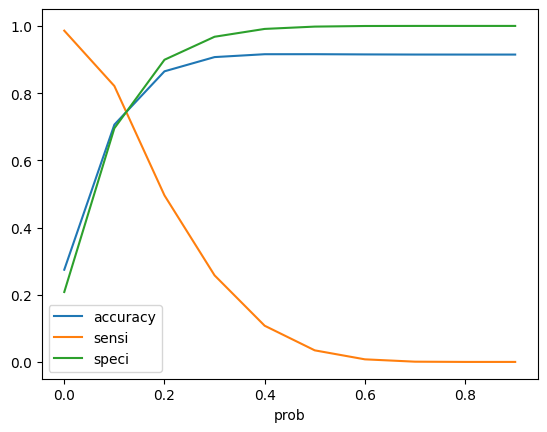

In [38]:
# 0.1 seems to be a good cut off in this case.
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Test our model and predict y_test

In [39]:
cutoff = 0.2
y_train_pred_final['final_pred'] = y_train_pred_final.HeartDisease_Prob.apply(lambda x: 1 if x>cutoff else 0)
y_train_pred_final.head()

,Actual,HeartDisease_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_pred
148821,0,0.058487,1,0,0,0,0,0,0,0,0,0,0
113787,0,-0.001036,0,0,0,0,0,0,0,0,0,0,0
114251,0,0.061311,1,0,0,0,0,0,0,0,0,0,0
311048,0,0.073514,1,0,0,0,0,0,0,0,0,0,0
50914,1,0.202933,1,1,1,0,0,0,0,0,0,0,1


## Lets make prediction on test data now

In [40]:
# Adding a constant variable 
X_test_new = X_test[rfe_columns]
X_test_new.drop(['AgeCategory_35-39','Race_White'], axis=1, inplace=True)
X_test_new.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,SleepTime,Asthma,...,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,-0.614666,-0.838727,-0.271204,-0.200086,-0.424638,-0.489988,-0.401087,-0.383521,-0.067337,-0.391987,...,-0.329345,-0.268581,-0.284974,-0.159494,-0.277486,-0.307359,-0.34893,-0.643515,-0.189359,-0.742061
1,2.438082,-0.838727,-0.271204,-0.200086,-0.424638,-0.489988,-0.401087,-0.383521,-0.761989,-0.391987,...,-0.329345,-0.268581,-0.284974,-0.159494,-0.277486,3.253527,-0.34893,-0.643515,-0.189359,1.347598
2,-0.269190,-0.838727,-0.271204,-0.200086,-0.424638,-0.489988,-0.401087,-0.383521,-0.761989,-0.391987,...,-0.329345,-0.268581,-0.284974,-0.159494,-0.277486,-0.307359,-0.34893,-0.643515,-0.189359,1.347598
3,-0.798396,-0.838727,-0.271204,-0.200086,-0.424638,-0.489988,-0.401087,-0.383521,0.627314,-0.391987,...,-0.329345,-0.268581,-0.284974,-0.159494,-0.277486,3.253527,-0.34893,1.553965,-0.189359,-0.742061
4,-0.085460,1.192284,-0.271204,-0.200086,-0.424638,-0.489988,-0.401087,-0.383521,0.627314,-0.391987,...,-0.329345,-0.268581,-0.284974,-0.159494,-0.277486,-0.307359,-0.34893,-0.643515,-0.189359,-0.742061


In [41]:
# Make predictions
y_test_pred = lm.predict(X_test_new)
y_test_pred[:10]

array([ 0.00265328, -0.04505724, -0.00999008, -0.0141527 ,  0.02533103,
        0.06179695, -0.04395014, -0.01243612, -0.03131729,  0.02074264])

In [42]:
# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_test_pred)
y_pred_df.head()
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,HeartDisease
290281,0
65173,0
58744,0
207715,0
168868,0


In [43]:
# Removing index for both dataframes to append them side by side 
y_pred_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [44]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_df],axis=1)
y_pred_final.head()

,HeartDisease,0
0,0,0.002653
1,0,-0.045057
2,0,-0.009990
3,0,-0.014153
4,0,0.025331


In [45]:
# Rename the column
y_pred_final = y_pred_final.rename(columns={0: 'HeartDidease_Prob'})
y_pred_final.head()

,HeartDisease,HeartDidease_Prob
0,0,0.002653
1,0,-0.045057
2,0,-0.009990
3,0,-0.014153
4,0,0.025331


In [46]:
# Set final prediction based on cutoffof 0.1
y_pred_final['final_prediction'] = y_pred_final['HeartDidease_Prob'].apply(lambda x: 1 if x>cutoff else 0)
y_pred_final.head()

,HeartDisease,HeartDidease_Prob,final_prediction
0,0,0.002653,0
1,0,-0.045057,0
2,0,-0.009990,0
3,0,-0.014153,0
4,0,0.025331,0


In [47]:
confusion = metrics.confusion_matrix(y_pred_final.HeartDisease, y_pred_final.final_prediction )
confusion

array([[78911,  8737],
       [ 4174,  4117]])

In [48]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [49]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.4965625376914727

In [50]:
# Let us calculate specificity
TN / float(TN+FP)

0.9003171778021175

In [51]:
# Accuracy
(TP+TN)/(TP+TN+FP+FN)

0.865424905408645

## Conclusion

### The model seems to be have decent sensitivity and specificity. Hence this model seems to be reliable.

* Sensitivity is 50%
* Specificity is 90%
* Accuracy is 86%

## 2. Analyse the correlation between various diseases

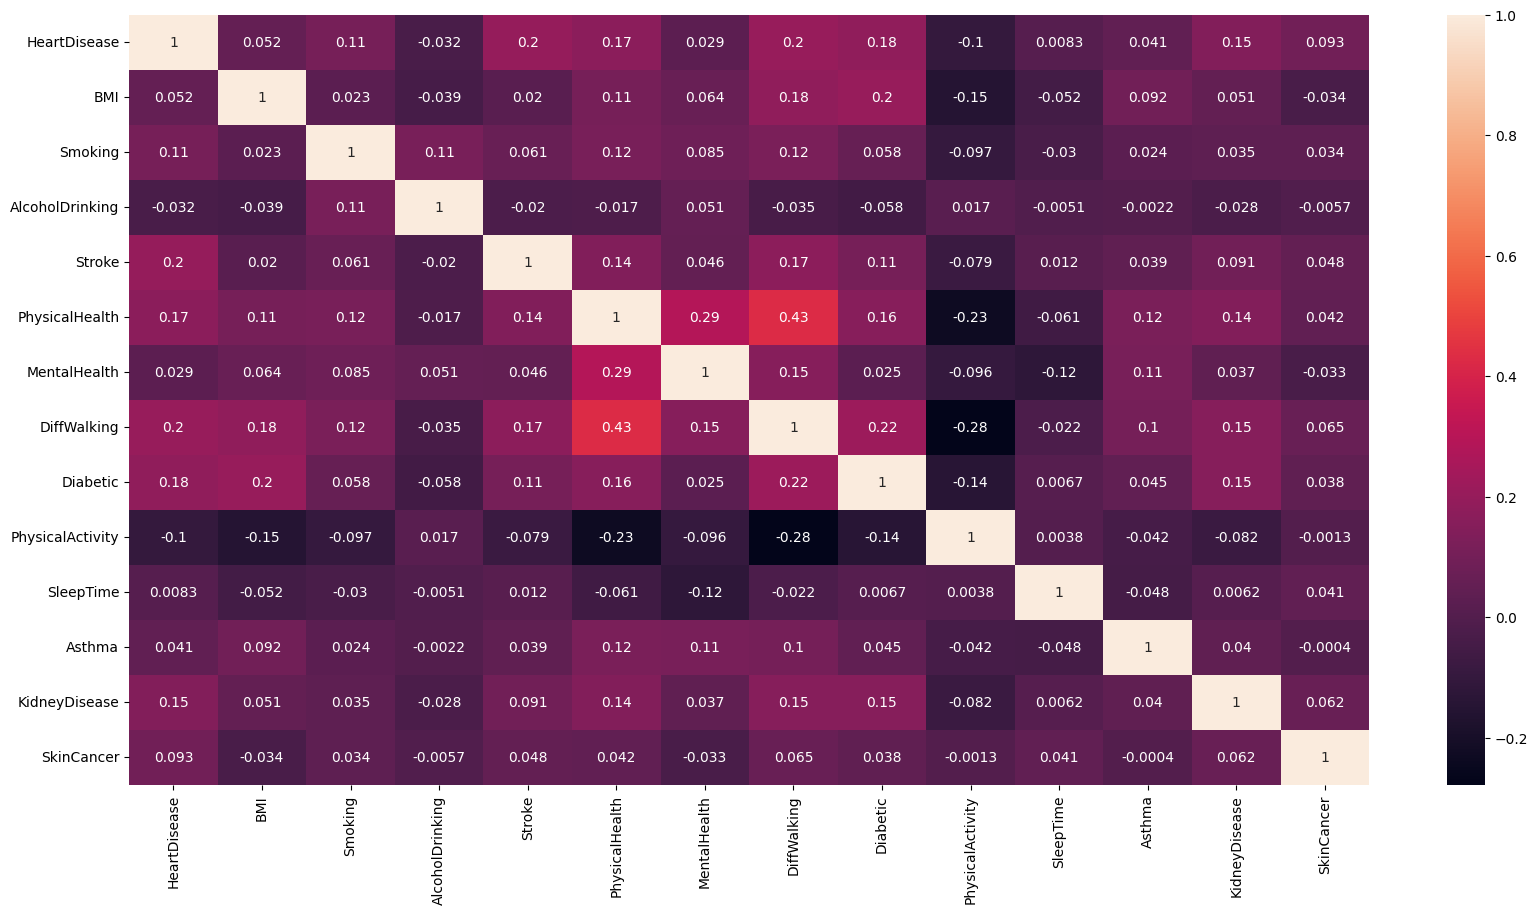

In [52]:
# Let us quickly check the heat map for original data
plt.figure(figsize = (20,10))
sns.heatmap(heart_orig.corr(),annot = True)
plt.show()

In [53]:
# Let us consider only the disease features
diseases = heart_orig[['HeartDisease', 'Stroke', 'Diabetic', 'KidneyDisease', 'SkinCancer']]
diseases.head()

,HeartDisease,Stroke,Diabetic,KidneyDisease,SkinCancer
0,0,0,1,0,1
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,0,0,0


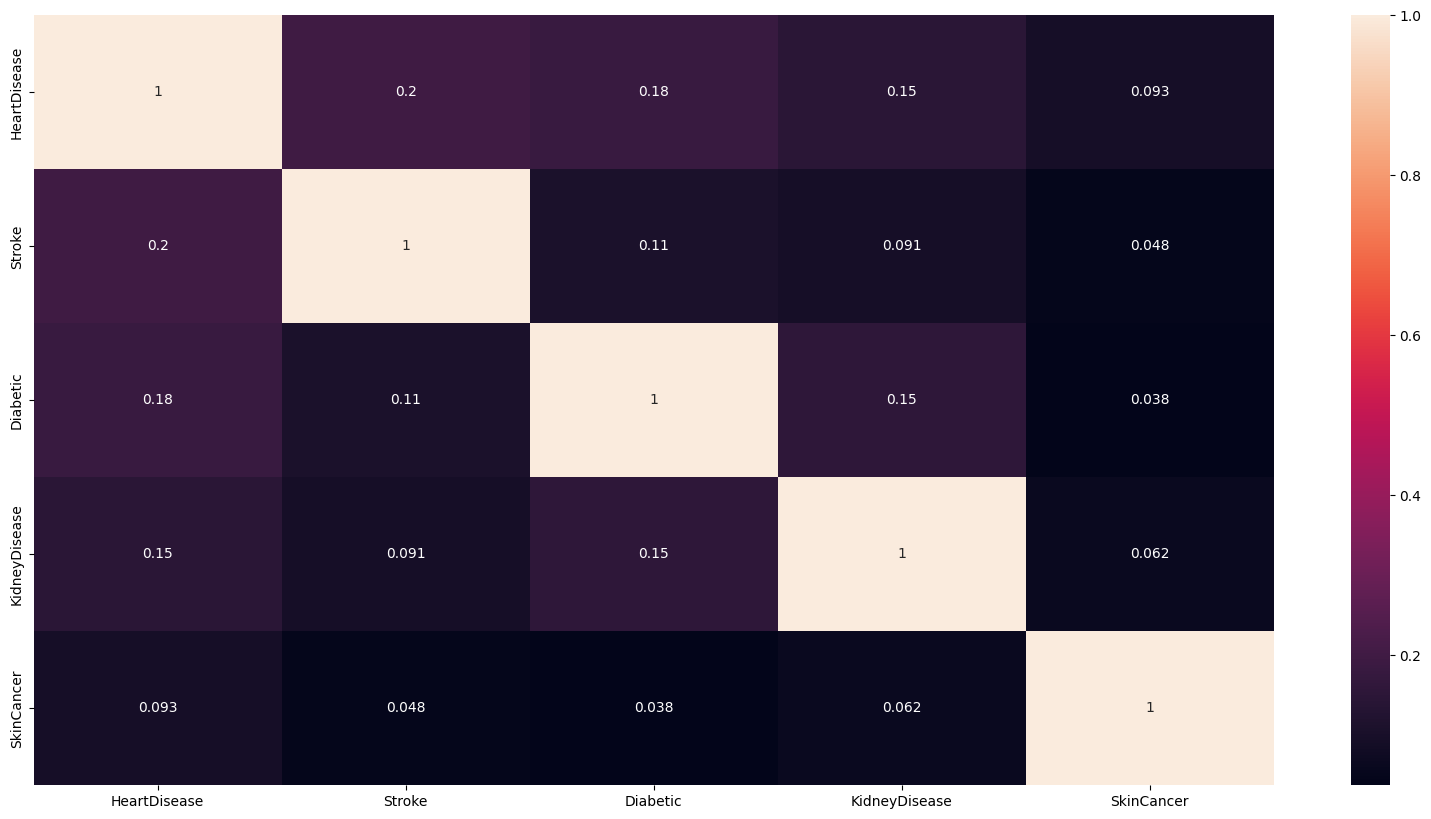

In [54]:
# check a heat map
plt.figure(figsize = (20,10))
sns.heatmap(diseases.corr(),annot = True)
plt.show()

### Observations
* Heart disease and stroke are correlated
* Diabetes is correlated with heart disease and Kidney disease. Less with Stroke.
* Skin cancer is not correlated with other 4 diseases.

In [55]:
# Let us understand if diabetes is influencing heart disease.
diabetics = heart_orig[heart_orig.Diabetic==1]
heart_d = sum(diabetics.HeartDisease)/len(diabetics)
print("The number of people with diabetes also having heart disease are")
print(heart_d)

heart_patients = heart_orig[heart_orig.HeartDisease==1]
diabs = sum(heart_patients.Diabetic)/len(heart_patients)
print("The number of people with heart disease also having diabetes are")
print(diabs)


The number of people with diabetes also having heart disease are
0.21952355276702123
The number of people with heart disease also having diabetes are
0.3272202535345048


One in three people (33%) having the heart disease are having diabetes. This can indicate that diabetes could be one of the main reasons of heart disease.

In [56]:
# Let us understand if diabetes is influencing kidney disease.
diabeticsk = heart_orig[heart_orig.Diabetic==1]
kidney_d = sum(diabeticsk.KidneyDisease)/len(diabeticsk)
print("The number of people with diabetes also having kidney disease are")
print(kidney_d)

kidney_patients = heart_orig[heart_orig.KidneyDisease==1]
diabsk = sum(kidney_patients.Diabetic)/len(kidney_patients)
print("The number of people with kidney disease also having diabetes are")
print(diabsk)

The number of people with diabetes also having kidney disease are
0.11281309739718641
The number of people with kidney disease also having diabetes are
0.39078020205450376


Kidney disease is even more influenced by diabetes. Nearly 40% are having diabetes. This surely indicates that diabetes has a role to play in the kidney disease.

## 3. Understand the influence of BMI on the diseases.

In [57]:
diseases_bmi = heart_orig[['HeartDisease', 'Stroke', 'Diabetic', 'KidneyDisease', 'SkinCancer', 'BMI']]
diseases_bmi.head(20)

,HeartDisease,Stroke,Diabetic,KidneyDisease,SkinCancer,BMI
0,0,0,1,0,1,16.60
1,0,1,0,0,0,20.34
2,0,0,1,0,0,26.58
3,0,0,0,0,1,24.21
4,0,0,0,0,0,23.71
5,1,0,0,0,0,28.87
6,0,0,0,0,1,21.63
7,0,0,1,0,0,31.64
8,0,0,0,1,0,26.45
9,0,0,0,0,0,40.69


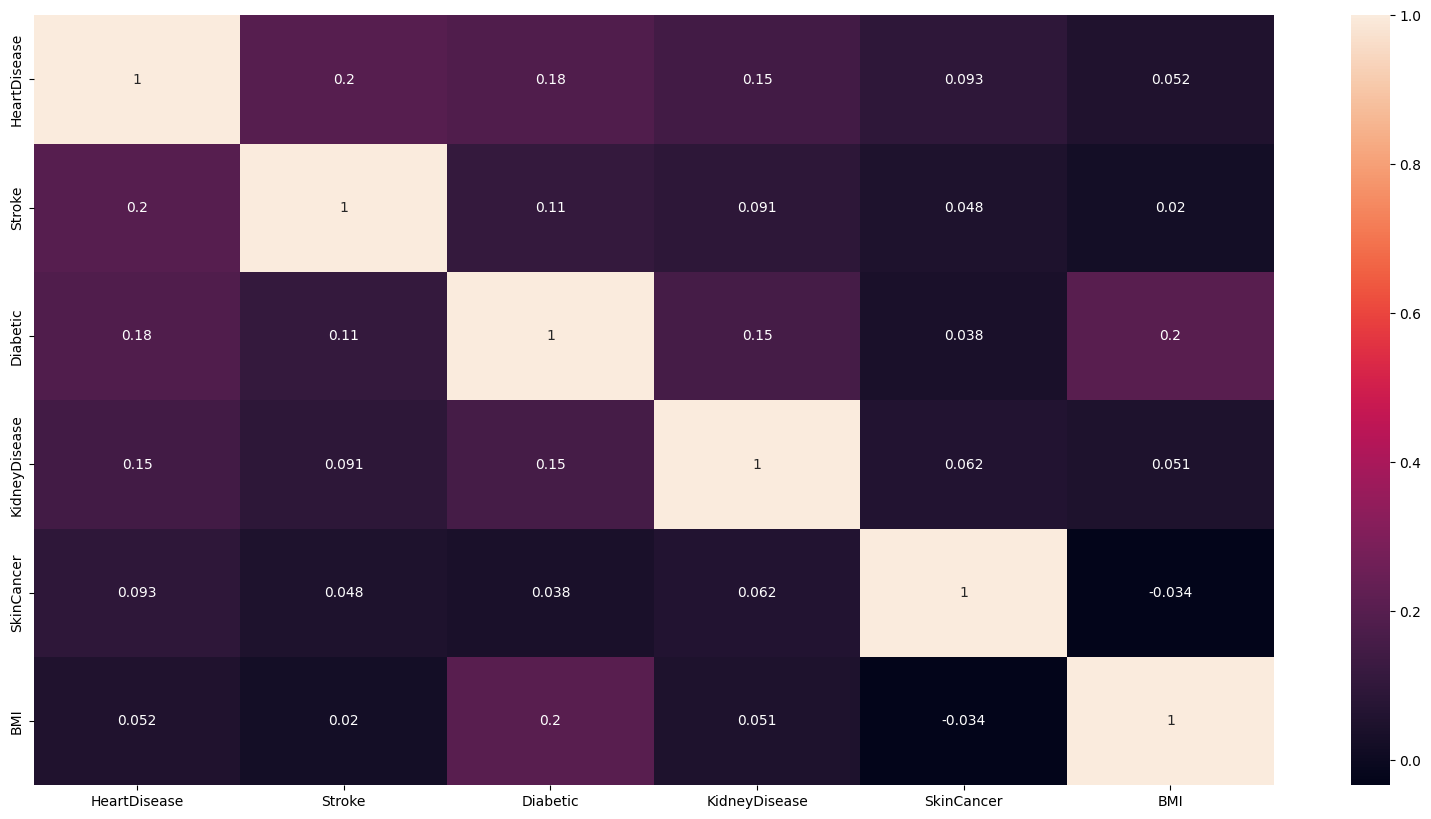

In [58]:
plt.figure(figsize=(20,10))
sns.heatmap(diseases_bmi.corr(), annot=True)
plt.show()

There is some hint here due to correlation between BMI and Diabetes, that higher BMI can cause Diabetes. Diabetes inturn causes heart disease and kidney disease as we learnt in previous analysis..